In [1]:
%load_ext autoreload
%autoreload 2

from subprocess import Popen, PIPE
import numpy as np
import json
import torch
import matplotlib.pyplot as plt

In [137]:
from base_env import *
env = BaseEnv()
env.reset()
obs = env.observation()

p = RandomPolicy()
a = p(obs)
obs, _, _, _ = env.step(a)
env.save()
env.load()

mean: 2.85


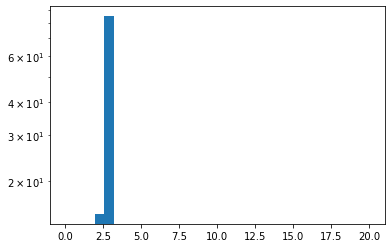

In [143]:
from base_env import * 
env = BaseEnv()

class Policy:
    def __init__(self):
        self.instument_pool = [0, 1, 2]
        
    def __call__(self, observation):
        raise NotImplementedError()
    
class RandomPolicy(Policy):
    def __call__(self, observation):
        shape = observation['info']['shape']
        iid = int(np.random.choice(self.instument_pool))
        a1 = np.random.randint(shape[0])
        a2 = np.random.randint(shape[0])
        return Action(iid, [a1, a2])

p = RandomPolicy()
res = []
gamma = 1.0 # 0.999

for ep in range(100):
    r_history = [0]
    env.reset()
    obs = env.observation()
    for i in range(int(1e3)): 
        best = (-1e9, None) 
        for i in range(20):
            action = p(obs)
            env.save()      
            _, r, _, _ = env.step(action) 
            # print('try:', action, 'reward:', r)
            if r > best[0]: best = (r, action)     
            env.load()
            
        action = best[1] 
        obs, r, done, _ = env.step(action) 
        # print('do:', action, 'reward:', r)
 
        r_history.append(r_history[-1] * gamma + r) 
        if done: break

    # print(r_history[-1])
    res.append(r_history[-1])
    # plt.plot(r_history)
    # plt.show()
               
plt.hist(res, range=(0, 20), bins=31, log=1);
print('mean:', np.mean(res))

In [4]:
from torch_geometric.data import Data

# with open('../cpp_backend/cmake-build-debug/graph.json') as f:
#      j = json.loads(''.join(f.readlines()))
    
with open('graph.json') as f:
    j = json.loads(''.join(f.readlines()))

def construct_data(j):
    num_edges = len(j['e'])
    num_vertices = len(j['v'])
    
    d = Data() 
    d.edge_index = torch.zeros(2, num_edges).long()
    d.train_mask = torch.zeros(num_vertices).bool()
    d.test_mask = torch.zeros(num_vertices).bool()
    d.val_mask = torch.zeros(num_vertices).bool()
    d.edge_attr = torch.zeros(num_edges, 1).float()
    
    d.x = torch.zeros(num_vertices, 1).float()
    d.y = torch.zeros(num_vertices).long()
     
    for i, (id, tag, _) in enumerate(j['v']):
        d.x[id] = 0
        d.y[id] = tag
        
        d.train_mask[id] = (id % 3) == 0 
        d.val_mask[id] = (id % 3) == 1 
        d.test_mask[id] = (id % 3) == 2
        
    for i, (v, u, tag) in enumerate(j['e']):
        d.edge_index[0][i] = v
        d.edge_index[1][i] = u
        d.edge_attr[i][0] = tag
        
    return d

d = construct_data(j)
print(d)

Data(edge_attr=[35, 1], edge_index=[2, 35], test_mask=[21], train_mask=[21], val_mask=[21], x=[21, 1], y=[21])


In [6]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, MessagePassing
# from cg_conv import CGConv
from torch_geometric.nn.conv.cg_conv import CGConv

data = construct_data(j)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.conv1 = GATConv(1, 2, heads=1, dropout=0.0)
        self.lin1 = torch.nn.Linear(1, 4)
        self.conv1 = CGConv(channels=4, dim=1)
        self.conv2 = CGConv(channels=4, dim=1)
        # self.conv2 = GATConv(1, 4, heads=1, concat=True, dropout=0.6)
        self.lin2 = torch.nn.Linear(4, 2)
        # self.conv2 = GATConv(1, 4, heads=1, concat=True, dropout=0.6)

    def forward(self, data):
        x = data.x    
        
        # x = F.dropout(data.x, p=0.2, training=self.training)
        # x = F.leaky_relu(self.conv1(x, data.edge_index, data.edge_attr))
        # x = self.lin(x) 
        
        x = self.lin1(x)
        x = self.conv1(x, data.edge_index, data.edge_attr)
        x = self.conv2(x, data.edge_index, data.edge_attr)
        x = self.lin2(x)
        
        # x = F.dropout(x, p=0.6, training=self.training)
        # x = self.conv2(x, data.edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3, weight_decay=1e-5)

def train():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.detach().numpy()


def test():
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        # print(logits)
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


for epoch in range(1, 500):
    loss = train()
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 1 == 0:
        print(log.format(epoch, *test()) + ' Loss: {:.4f}'.format(loss))

Epoch: 001, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.7898
Epoch: 002, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.7708
Epoch: 003, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.7536
Epoch: 004, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.7382
Epoch: 005, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.7248
Epoch: 006, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.7133
Epoch: 007, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.7037
Epoch: 008, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6959
Epoch: 009, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6900
Epoch: 010, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6857
Epoch: 011, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6829
Epoch: 012, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6812
Epoch: 013, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6803
Epoch: 014, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6799
Epoch: 015, Train: 0.5714, Val: 0.2857, Test: 0.7143 Loss: 0.6795
Epoch: 016

In [104]:
x = [
6.020,
5.980,
6.373,
6.784,
7.157,
7.020,
6.725,
7.314,
6.961,
7.706,
8.000,
7.569,
6.882,
7.647,
7.137,
7.235,
7.392,
7.745,
7.529,
7.510,
7.255,
7.980,
7.588,
7.627,
7.627,
7.804,
7.255,
7.667,
8.059,
7.196,
7.333,
6.922,
7.176,
7.471,
7.510,
7.686,
7.745,
7.882,
7.824,
8.275,
7.725,
7.549,
7.196,
8.294,
8.098,
7.176,
8.373,
6.569,
7.275,
7.137,
7.392,
7.000,
6.627,
6.588,
6.706,
6.824,
6.784,
7.157,
7.667,
7.333,
7.118,
7.922,
8.098,
8.157,
7.608,
7.529,
7.765,
7.255,
8.000,
7.059,
7.863,
7.314,
7.216,
7.431,
7.902,
8.078,
7.725,
8.000,
7.608,
7.020,
7.490,
8.020,
7.882,
7.431,
7.647,
7.451,
6.569,
7.431,
7.961,
7.216,
7.137,
7.471,
7.510,
7.608,
8.373,
7.529,
7.412,
6.824,
7.216,
7.294,
7.549,
7.961,
8.353,
7.471,
7.196,
7.627,
7.765,
7.314,
7.784,
8.235,
7.725,
8.294,
8.118,
8.176,
7.922,
7.373,
]

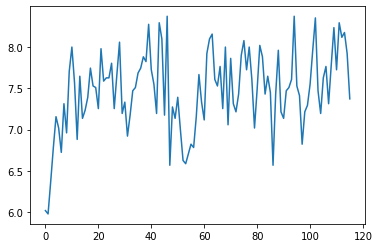

In [105]:
plt.plot(x)